In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
mu, sigma = 0, 1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1)
s[0]

s = stats.norm([10],[2])
s.pdf(10)[0]
s.rvs()

9.104120929626612

In [3]:
#We want to find expected value of a set of samples fron a distribution
def expected_value_sampling(samples):
    return (1/len(samples))*sum([s for s in samples])

In [16]:
#Test for calculating expected value of samples of normal ditribution

mu, sigma = 10, 1 # mean and standard deviation
N_sizes = [100,200,500,1000,2000,100000]
for N in (N_sizes):
    distribution = stats.norm([mu],[sigma])
    s = distribution.rvs(N)
    print(expected_value_sampling(s))

9.922143177082267
9.966721633512929
10.009746999487437
9.974121140772978
9.993822732712388
10.001839633234345


In [4]:
def proposed_density_random_walk(u_t, beta):
    return stats.norm([u_t],[beta**2])

In [5]:
def MH_A_1D(beta,N,proposed_density):
    """
    Implementation of Metropolis Hastings Algorithm for 1D distributions.
    
    1. Choose u(1) with π(u(1))>0.
    2. At state u(t), sample a proposal u′ from density q(u′|u(t)).
    3. Accept sample u′ with probability:
        α(u′|u(i)) = min(1,π(u′)q(u(t)|u′)/π(u(i))q(u′|u(t))).
        
    Inputs:
    beta (float) = beta used in random walk proposed density
    N (Int) = Number of steps taken in algorthim
    
    """
    # initalize
    u_0 = 0 
    u_t = 0
    posterior_distribution_pi = stats.norm([10],[1])
    proposed_density = proposed_density
    u_samples = [u_0]
    list_acceptance_probaility = []
    
    # ?Methods of getting the best beta?
    # Some cases theory; normal distribution we can calculte it -> Average acceptance rate 0.234.
    beta = beta
    
    for t in range(N):
        
        # sample a proposal u′ from density q(u′|u(t)) 
        proposal_density_t = proposed_density(u_t,beta)
        u_prime = proposal_density_t.rvs()
        
        #?Ask about proposed density for u prime?
        # proposal density q(u(t)|u′) used in (3)
        proposal_density_prime = proposed_density(u_prime,beta)
        
        # π(u′)q(u(t)|u′)
        numerator = posterior_distribution_pi.pdf(u_prime)*proposal_density_prime.pdf(u_t)
        # π(u(t))q(u′|u(t))
        denominator = posterior_distribution_pi.pdf(u_t)*proposal_density_t.pdf(u_prime)
        
        acceptance_probaility = float(min([1,numerator/denominator]))
        list_acceptance_probaility.append(acceptance_probaility)
        
        rv = np.random.uniform(0,1,1)
        
        if rv <= acceptance_probaility:
            #Accept
            u_t = u_prime
            u_samples.append(u_t)
        else:
            #Reject
            u_t = u_t
            u_samples.append(u_t)
    
    #?Buring what percentage of samples?
    #Burn first 20 percent of samples because we pick a random u_0 which could be very far from where we want to sample from
    return u_samples , list_acceptance_probaility

## 1.3 - Autocorreltation function to see how correlated our samples. This is for our estimator in our case the mean of the samples

In [4]:
def covariance_between_elements(list_samples):
    """
    Input: Takes in a list of samples, that where produced by MCMC method.
    Returns: A list of Cov(u_j,u_i) for all differences of j-i up to n
    
    Note: Cov(u_i,u_j) = Cov(u_i+1,u_j+1), we use this property of markov chains since samples are independant of
    one another.
    """
    
    n = len(list_samples)
    u_mean = np.mean(list_samples)
    
    # 1/L where L is the number of comparisons L = N-1,N-2,...,1
    L = [i for i in range(n-1,0,-1)]
    
    return [(1/L[x-1]-1)*sum([(list_samples[0+i]-u_mean)*(list_samples[x+i]-u_mean) for i in range(n) if x+i < n]) for x in range(1,n)]

#Asymptotic variance for different values of N and using our optimal beta
def asymptotic_variance(list_samples):
    """
    Asymptotic variance = Var(U_0) + 2*sum(Cov(U_0,U_i))
    Note that U_i's are sampled from the posterior distribution pi we are trying to model.
    
    This is the asymptotic variance of the value of our estimator, in our case the mean of samples.
    """
    n = len(list_samples)
    u_0 = list_samples[0]
        
    u_variance = np.var(list_samples)
    cov_elementwise = covariance_between_elements(list_samples)
    
    return u_variance + 2*sum(cov_elementwise)


In [16]:
# 𝜌𝑓(𝜏) is the normalized autocorrelation function
# p 𝑓(𝜏)=p𝑓(𝜏)/p 𝑓(0)

def c_tau(list_samples, tau):
    
    u_mean = np.mean(list_samples)
    N = len(list_samples)
    summ = sum([(list_samples[i]-u_mean)*(list_samples[i+tau]-u_mean) for i in range(0,N-tau)])

    return (1/(N-tau))*summ
    
#integrated autocorrelation time : 1+2∑𝜏=1𝑁𝜌̂ 𝑓(𝜏)
def autocorrelation_M(list_samples, M):
    """
    autocorrelation = 1 + 2*sum(pf(tau))
    Note that U_i's are sampled from the posterior distribution pi we are trying to model.
    
    This function you can change to what value of M you should be able to add too, that is the different lags.
    """ 
    c_0 = c_tau(list_samples, 0)
    return 1 + 2*sum([c_tau(list_samples, i)/c_0 for i in range(1,M+1)])


In [6]:
samples = MH_A_1D(2.3,5000,proposed_density_random_walk)[0]

In [7]:
len(samples)

5001

In [45]:
autocorrelation_M(samples, 7)

14.81104389150734

In [9]:
M_s = range(1,len(samples),25)
asy_Var_M_s = []

for M in M_s:
    print(M)
    asy_Var_M_s.append(autocorrelation_M(samples, M))

1
26
51
76
101
126
151
176
201
226
251
276
301
326
351
376
401
426
451
476
501
526
551
576
601
626
651
676
701
726
751
776
801
826
851
876
901
926
951
976
1001
1026
1051
1076
1101
1126
1151
1176
1201
1226
1251
1276
1301
1326
1351
1376
1401
1426
1451
1476
1501
1526
1551
1576
1601
1626
1651
1676
1701
1726
1751
1776
1801
1826
1851
1876
1901
1926
1951
1976
2001
2026
2051
2076
2101
2126
2151
2176
2201
2226
2251
2276
2301
2326
2351
2376
2401
2426
2451
2476
2501
2526
2551
2576
2601
2626
2651
2676
2701
2726
2751
2776
2801
2826
2851
2876
2901
2926
2951
2976
3001
3026
3051
3076
3101
3126
3151
3176
3201
3226
3251
3276
3301
3326
3351
3376
3401
3426
3451
3476
3501
3526
3551
3576
3601
3626
3651
3676
3701
3726
3751
3776
3801
3826
3851
3876
3901
3926
3951
3976
4001
4026
4051
4076
4101
4126
4151
4176
4201
4226
4251
4276
4301
4326
4351
4376
4401
4426
4451
4476
4501
4526
4551
4576
4601
4626
4651
4676
4701
4726
4751
4776
4801
4826
4851
4876
4901
4926
4951
4976


In [10]:
asy_Var_M_s

[2.490074513396963,
 7.5958813487342995,
 8.307188264596677,
 9.181525776153505,
 10.18574216748419,
 11.505552481809003,
 11.665897439912364,
 11.230958918916105,
 13.486387706061583,
 13.625886818593898,
 12.304153856837827,
 11.996485456848987,
 12.742826463687855,
 12.792874668884833,
 13.271244768255043,
 11.62581178994088,
 11.126517833598097,
 9.95698803013741,
 10.035973930762013,
 8.581955381925518,
 7.266477369625369,
 6.432439492978672,
 5.487857216538707,
 4.7542159396993195,
 5.256418642374156,
 5.554211001965837,
 8.03876566193529,
 7.149100319661369,
 7.713125848832629,
 9.357688586248386,
 9.760112079602568,
 10.10964534475847,
 11.96269733951276,
 12.360361000838124,
 13.945984039560146,
 13.618655415663591,
 15.544816584401046,
 17.84475225765647,
 19.3226482892932,
 19.66981874495884,
 21.081808381599657,
 20.853027860249938,
 20.784835684666326,
 20.045601534890977,
 20.383634269325157,
 19.44053020801698,
 19.783077523667142,
 19.255896149585475,
 18.90951504754025

Text(0.5, 0, 'M')

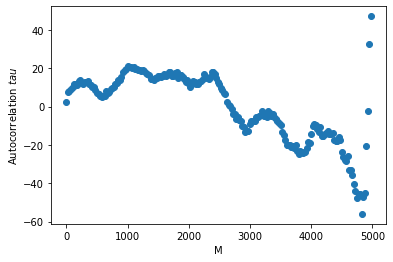

In [11]:
fig, ax = plt.subplots()
plt.scatter(M_s,asy_Var_M_s)

ax.set_ylabel('Autocorrelation $tau$')
ax.set_xlabel('M')

## 2 -  Non reversible metropolis hastings algorithms

In [9]:
# smaller asymptotic variance for non-reversible

In [10]:
def proposed_density_random_walk(u_t, beta):
    return stats.norm([u_t],[beta**2])

In [11]:
def Non_Reversible_MH_A(beta,N):
    """
    Implementation of Metropolis Hastings Algorithm for 1D distributions.
    
    1. Choose u(1) with π(u(1))>0.
    2. At state u(t), sample a proposal u′ from density q(u′|u(t)).
    3. Accept sample u′ with probability:
        α(u′|u(i)) = min(1,π(u′)q(u(t)|u′)/π(u(i))q(u′|u(t))).
        
    Inputs:
    beta (float) = beta used in random walk proposed density
    N (Int) = Number of steps taken in algorthim
    
    """
    # initalize
    u_0 = 1 
    u_t = 1
    posterior_distribution_pi = stats.norm([10],[1])
    u_samples = [u_0]
    list_acceptance_probaility = []
    all_samples = []
    
    rv_z = np.random.uniform(0,1,1)
    z = 0 
    if rv_z < 0.5:
        z = 1
    else:
        z = -1
        
    a = beta
    gamma_distribution = stats.gamma(a)
    
    # zi=yi+γ·yip,γ∼Γ(α,β);
    
    for t in range(N):
        
        if z > 0: 
        
            # sample a proposal u′ from density f(u′|u(t))
            u_prime = u_t + gamma_distribution.rvs()

            # π(u′)g(u(t)|u′)
            numerator = posterior_distribution_pi.pdf(u_prime)*gamma_distribution.pdf(u_prime - u_t)
            
            # π(u(t))f(u′|u(t))
            denominator = posterior_distribution_pi.pdf(u_t)*gamma_distribution.pdf(u_prime - u_t)

            acceptance_probaility = float(min([1,numerator/denominator]))
            list_acceptance_probaility.append(acceptance_probaility)
        
        else:
            
            # sample a proposal u′ from density g(u′|u(t))
            u_prime = u_t - gamma_distribution.rvs()
            
            # π(u′)f(u(t)|u′)
            numerator = posterior_distribution_pi.pdf(u_prime)*gamma_distribution.pdf(u_t - u_prime)
            
            # π(u(t))g(u′|u(t))
            denominator = posterior_distribution_pi.pdf(u_t)*gamma_distribution.pdf(u_t - u_prime)
            
            acceptance_probaility = float(min([1,numerator/denominator]))
            list_acceptance_probaility.append(acceptance_probaility)
        
        rv = np.random.uniform(0,1,1)
        
        all_samples.append(u_prime)
        
        if rv <= acceptance_probaility:
            #Accept
            u_t = u_prime
            u_samples.append(u_t)
            z = z 
        else:
            #Reject
            u_t = u_t
            u_samples.append(u_t)
            z = -1*z
    
    return u_samples, all_samples, list_acceptance_probaility

## 3 -  Non reversible vs Reversible on 1D gaussian (10, 1)

In [12]:
u_samples, all_samples, list_acceptance_probaility = Non_Reversible_MH_A(2.3,5000)

In [13]:
samples = MH_A_1D(2.3,5000,proposed_density_random_walk)[0]

In [14]:
len(samples), len(u_samples)

(5001, 5001)

In [17]:
covariance_reversible = [c_tau(samples,i) for i in range(25)]
covariance_non_reversible = [c_tau(u_samples,i) for i in range(25)]

In [22]:
lag_reversible = [i for i in range(25)]
lag_non_reversible = [i for i in range(25)]

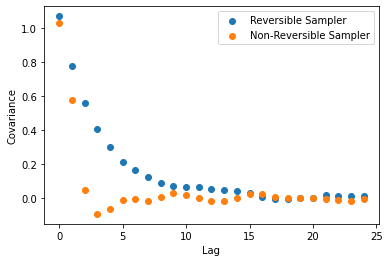

In [23]:
fig, ax = plt.subplots()
plt.scatter(lag_reversible,covariance_reversible,label = "Reversible Sampler")
plt.scatter(lag_non_reversible,covariance_non_reversible,label = "Non-Reversible Sampler")

ax.set_ylabel('Covariance')
ax.set_xlabel('Lag')
ax.legend()

## 4 -  Try with new functions with Non Reversible Sampler: Mixture Gaussians, log Normal, Rosenbrook function

In [24]:
def gaussian_mixture_pdf(x, pi_s):
    """
    pi_s is a list of normal distributions made with stats.norm([mu],[sigma])
    x is the value we want to evaluate
    """
    return sum([pi.pdf(x) for pi in pi_s])

In [30]:
def Non_Reversible_MH_A_Gaussain_Mixtures(beta,N,gaussian_posterior):
    # initalize
    u_0 = 1 
    u_t = 1
    u_samples = [u_0]
    list_acceptance_probaility = []
    all_samples = []
    
    rv_z = np.random.uniform(0,1,1)
    z = 0 
    if rv_z < 0.5:
        z = 1
    else:
        z = -1
        
    a = beta
    gamma_distribution = stats.gamma(a)
    
    # zi=yi+γ·yip,γ∼Γ(α,β);
    
    for t in range(N):
        
        if z > 0: 
        
            # sample a proposal u′ from density f(u′|u(t))
            u_prime = u_t + gamma_distribution.rvs()

            # π(u′)g(u(t)|u′)
            numerator = gaussian_mixture_pdf(u_prime,gaussian_posterior)*gamma_distribution.pdf(u_prime - u_t)
            
            # π(u(t))f(u′|u(t))
            denominator = gaussian_mixture_pdf(u_t,gaussian_posterior)*gamma_distribution.pdf(u_prime - u_t)

            acceptance_probaility = float(min([1,numerator/denominator]))
            list_acceptance_probaility.append(acceptance_probaility)
        
        else:
            
            # sample a proposal u′ from density g(u′|u(t))
            u_prime = u_t - gamma_distribution.rvs()
            
            # π(u′)f(u(t)|u′)
            numerator = gaussian_mixture_pdf(u_prime,gaussian_posterior)*gamma_distribution.pdf(u_t - u_prime)
            
            # π(u(t))g(u′|u(t))
            denominator = gaussian_mixture_pdf(u_t,gaussian_posterior)*gamma_distribution.pdf(u_t - u_prime)
            
            acceptance_probaility = float(min([1,numerator/denominator]))
            list_acceptance_probaility.append(acceptance_probaility)
        
        rv = np.random.uniform(0,1,1)
        
        all_samples.append(u_prime)
        
        if rv <= acceptance_probaility:
            #Accept
            u_t = u_prime
            u_samples.append(u_t)
            z = z 
        else:
            #Reject
            u_t = u_t
            u_samples.append(u_t)
            z = -1*z
    
    return u_samples, all_samples, list_acceptance_probaility

In [31]:
pi_1 = stats.norm([10],[1])
pi_2 = stats.norm([5],[1])

In [32]:
samples = Non_Reversible_MH_A_Gaussain_Mixtures(0.21,5000,[pi_1,pi_2])[0]

<ipython-input-30-722381b93d62>:61: RuntimeWarning: invalid value encountered in true_divide
  acceptance_probaility = float(min([1,numerator/denominator]))
<ipython-input-30-722381b93d62>:47: RuntimeWarning: invalid value encountered in true_divide
  acceptance_probaility = float(min([1,numerator/denominator]))


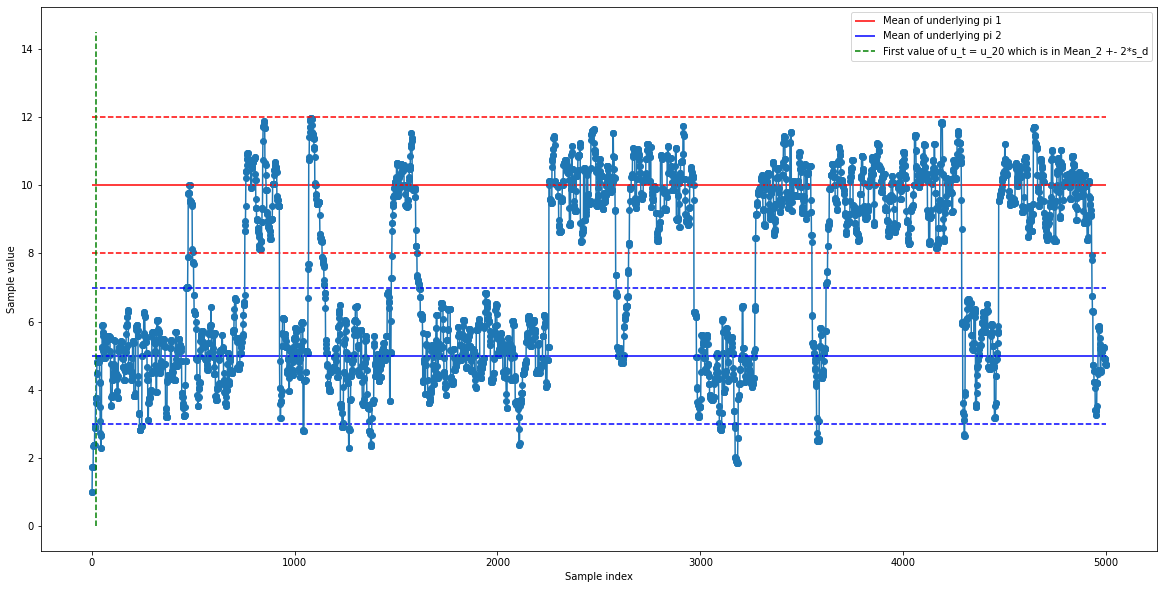

In [33]:
sample_index = [i for i in range(len(samples))]
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(sample_index,samples)
ax.scatter(sample_index,samples)

mean_1, mean_2 = 10, 5
s_d = 1
index = 0 

ax.hlines(mean_1, 0, len(samples), "r",label = "Mean of underlying pi 1")
ax.hlines(mean_1-2*s_d, 0, len(samples), "r",'--')
ax.hlines(mean_1+2*s_d, 0, len(samples), "r",'--')

ax.hlines(mean_2, 0, len(samples), "b",label = "Mean of underlying pi 2")
ax.hlines(mean_2-2*s_d, 0, len(samples), "b",'--') 
ax.hlines(mean_2+2*s_d, 0, len(samples), "b",'--')

for u in samples:
    index+=1
    if(u > mean_1-2*s_d or u > mean_2-2*s_d):
        break

ax.vlines(index, 0, 14.5, "g",'--',label = "First value of u_t = u_{} which is in Mean_2 +- 2*s_d".format(index))
ax.set_ylabel('Sample value')
ax.set_xlabel('Sample index')
ax.legend()

(array([0.00273211, 0.        , 0.        , 0.00910704, 0.00728564,
        0.00364282, 0.02185691, 0.01366057, 0.04553522, 0.01730338,
        0.04280311, 0.08560621, 0.09107044, 0.07740987, 0.1229451 ,
        0.19306933, 0.22130117, 0.20855131, 0.20399779, 0.22858681,
        0.18123018, 0.1438913 , 0.11474876, 0.09015974, 0.07832058,
        0.04826733, 0.02914254, 0.01730338, 0.01092845, 0.01001775,
        0.01183916, 0.00728564, 0.02185691, 0.07740987, 0.06374931,
        0.09107044, 0.13205214, 0.14662341, 0.20490849, 0.18396229,
        0.19762286, 0.23040822, 0.24953301, 0.19671215, 0.17576595,
        0.07832058, 0.07103494, 0.03642818, 0.03824959, 0.01912479]),
 array([ 0.99371793,  1.21328425,  1.43285056,  1.65241687,  1.87198318,
         2.09154949,  2.31111581,  2.53068212,  2.75024843,  2.96981474,
         3.18938105,  3.40894736,  3.62851368,  3.84807999,  4.0676463 ,
         4.28721261,  4.50677892,  4.72634524,  4.94591155,  5.16547786,
         5.38504417,  5.60

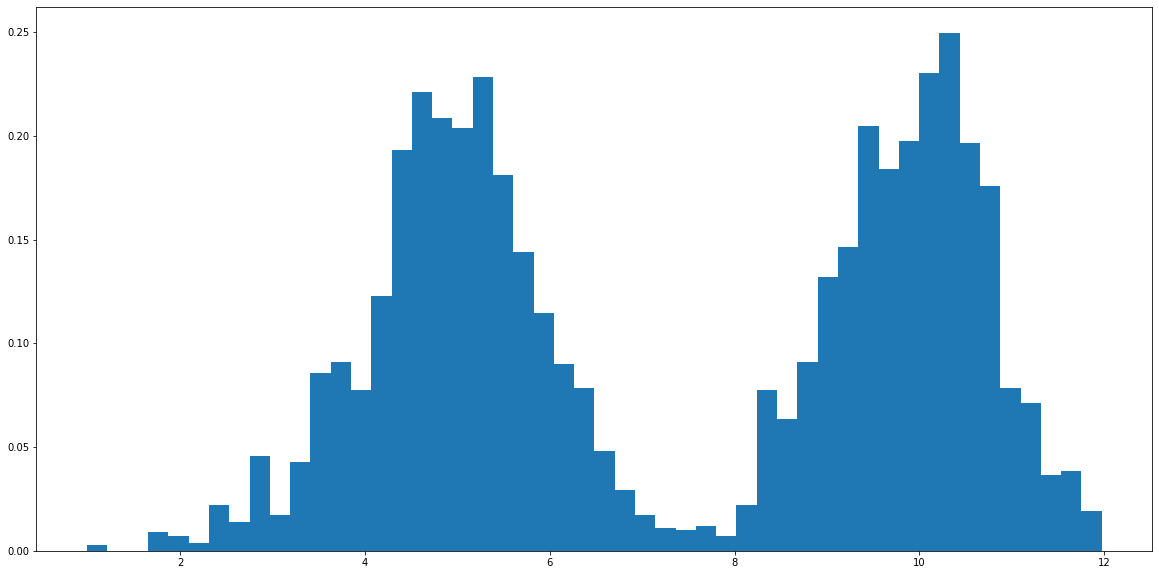

In [34]:
pi_s = [pi_1,pi_2]
fig, ax = plt.subplots(figsize=(20, 10))
plt.hist(samples,density=True,bins=50)

In [34]:
samples = Non_Reversible_MH_A_log_normal(0.21,5000)[0]

<ipython-input-33-050f24ea3293>:55: RuntimeWarning: invalid value encountered in double_scalars
  acceptance_probaility = float(min([1,numerator/denominator]))


In [35]:
samples

[1,
 1.0036247227217523,
 1.0627470039078726,
 1.0628085716550795,
 3.148604256546637,
 3.148626112668757,
 3.1488684119793033,
 3.1489406547012955,
 3.2824324589580978,
 6.0555564185124755,
 6.055615607980727,
 6.055962188679627,
 6.337717081674337,
 6.342623315768812,
 6.548328070676759,
 8.156723944641172,
 8.156794648025521,
 8.156877736649678,
 8.158990241479824,
 8.187505632503834,
 8.187510724713398,
 8.26185583741294,
 8.261860474761466,
 8.261861085659763,
 8.267657304217828,
 8.267675131786824,
 8.31958870900815,
 9.128666607281266,
 9.128666607281266,
 8.748031386399028,
 8.522502116774934,
 8.51221703853545,
 8.512209115463195,
 8.51220911541638,
 8.512207968531794,
 8.302900611730495,
 7.51240922051375,
 7.419954155156902,
 7.419951832922641,
 7.419951832922172,
 7.169140174524733,
 7.1691205914936145,
 7.157066852938059,
 6.9424683388125885,
 6.656683226600263,
 6.650259640550861,
 6.650259085828406,
 6.561978507324661,
 5.976871308974389,
 5.8291310708308215,
 5.81492066

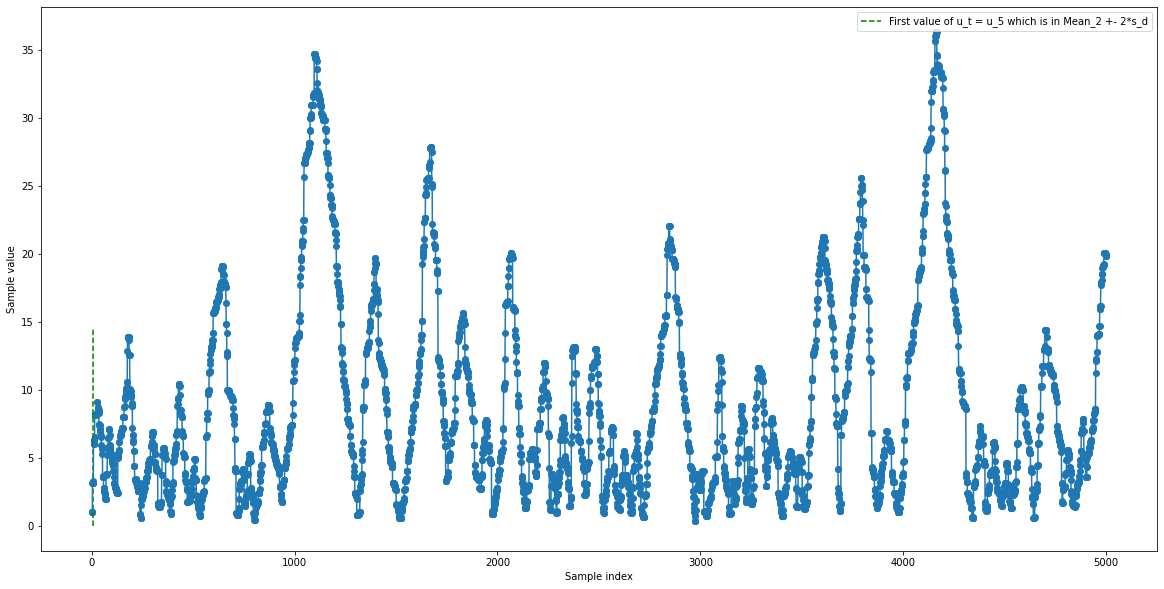

In [36]:
sample_index = [i for i in range(len(samples))]
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(sample_index,samples)
ax.scatter(sample_index,samples)

mean_1, mean_2 = 10, 5
s_d = 1
index = 0 

for u in samples:
    index+=1
    if(u > mean_1-2*s_d or u > mean_2-2*s_d):
        break

ax.vlines(index, 0, 14.5, "g",'--',label = "First value of u_t = u_{} which is in Mean_2 +- 2*s_d".format(index))
ax.set_ylabel('Sample value')
ax.set_xlabel('Sample index')
ax.legend()

(array([0.04948917, 0.08702309, 0.09258367, 0.11371388, 0.0889693 ,
        0.07812616, 0.0889693 , 0.07506784, 0.06255654, 0.06283457,
        0.03642181, 0.04531874, 0.03002714, 0.04365056, 0.02696882,
        0.04337253, 0.02808093, 0.03364152, 0.02252035, 0.01807189,
        0.01862795, 0.01862795, 0.02613473, 0.00945299, 0.01612569,
        0.01862795, 0.02224232, 0.01668174, 0.01278934, 0.00889693,
        0.01028707, 0.00389241, 0.00472649, 0.00305832, 0.00444846,
        0.00611664, 0.00305832, 0.00778481, 0.01000905, 0.00166817,
        0.00333635, 0.00583861, 0.00528255, 0.00611664, 0.0019462 ,
        0.00611664, 0.00500452, 0.00361438, 0.        , 0.00250226]),
 array([ 0.38205819,  1.10126364,  1.82046908,  2.53967453,  3.25887997,
         3.97808542,  4.69729086,  5.41649631,  6.13570175,  6.85490719,
         7.57411264,  8.29331808,  9.01252353,  9.73172897, 10.45093442,
        11.17013986, 11.88934531, 12.60855075, 13.3277562 , 14.04696164,
        14.76616708, 15.48

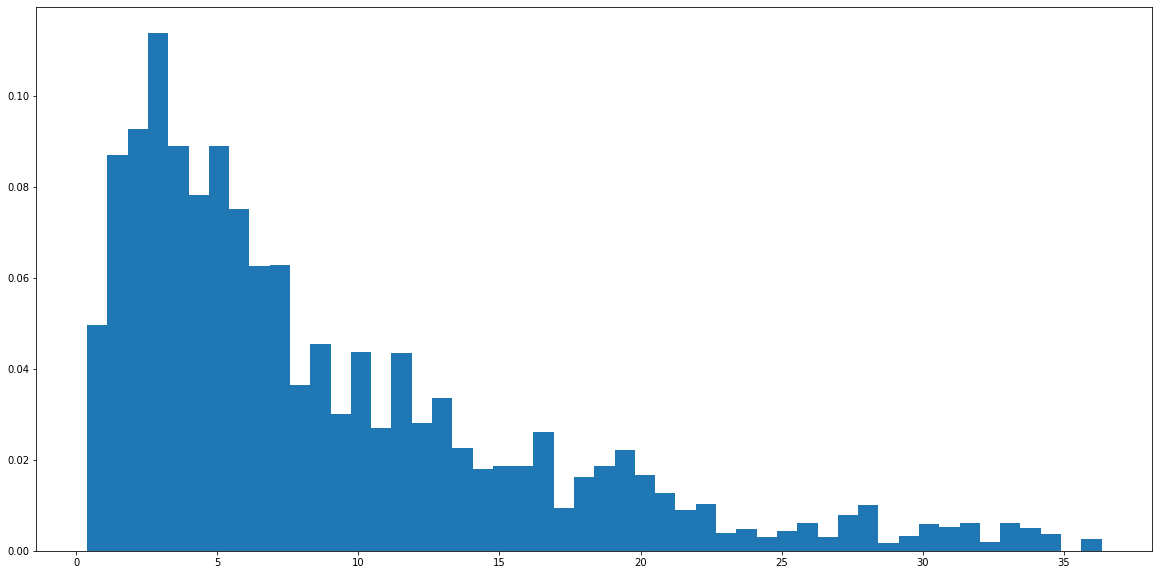

In [37]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.hist(samples,density=True,bins=50)

### 1.5.3 Rosenbrook function

$${\displaystyle f(x,y)=A\exp \left(-\left({\frac {(x-x_{o})^{2}}{2\sigma _{X}^{2}}}+{\frac {(y-y_{o})^{2}}{2\sigma _{Y}^{2}}}\right)\right).}$$


In [143]:
def pdf_rb(x):
    a = (x[1]-(x[0]**2))**2
    b = (1-x[1])**2
    return np.exp(-100*(a+b)/10)

In [ ]:
def pdf_gamma(point ,mu_x,mu_y,theta_x,theta_y):
    a = (point[0]-mu_x)**2/(2*theta_x**2)
    b = (point[1]-mu_y)**2/(2*theta_y**2)
    return np.exp(a+b)

In [144]:
def Non_Reversible_MH_A_RB(beta,N,rb,gamma):
    """
    Implementation of Metropolis Hastings Algorithm for 1D distributions.
    
    1. Choose u(1) with π(u(1))>0.
    2. At state u(t), sample a proposal u′ from density q(u′|u(t)).
    3. Accept sample u′ with probability:
        α(u′|u(i)) = min(1,π(u′)q(u(t)|u′)/π(u(i))q(u′|u(t))).
        
    Inputs:
    beta (float) = beta used in random walk proposed density
    N (Int) = Number of steps taken in algorthim
    
    """
    # initalize
    u_0 = [0,0] 
    u_t = [0,0]
    posterior_distribution_pi = rb
    u_samples = [u_0]
    list_acceptance_probaility = []
    all_samples = []
    
    rv_z = np.random.uniform(0,1,1)
    z = 0 
    if rv_z < 0.5:
        z = 1
    else:
        z = -1
        
    a = beta
    gamma_distribution = stats.gamma(a)
    
    # zi=yi+γ·yip,γ∼Γ(α,β);
    
    for t in range(N):
        
        if z > 0: 
        
            # sample a proposal u′ from density f(u′|u(t))
            u_prime = u_t + gamma_distribution.rvs()

            # π(u′)g(u(t)|u′)
            numerator = posterior_distribution_pi.pdf(u_prime)*gamma_distribution.pdf(u_prime - u_t)
            
            # π(u(t))f(u′|u(t))
            denominator = posterior_distribution_pi.pdf(u_t)*gamma_distribution.pdf(u_prime - u_t)

            acceptance_probaility = float(min([1,numerator/denominator]))
            list_acceptance_probaility.append(acceptance_probaility)
        
        else:
            
            # sample a proposal u′ from density g(u′|u(t))
            u_prime = u_t - gamma_distribution.rvs()
            
            # π(u′)f(u(t)|u′)
            numerator = posterior_distribution_pi.pdf(u_prime)*gamma_distribution.pdf(u_t - u_prime)
            
            # π(u(t))g(u′|u(t))
            denominator = posterior_distribution_pi.pdf(u_t)*gamma_distribution.pdf(u_t - u_prime)
            
            acceptance_probaility = float(min([1,numerator/denominator]))
            list_acceptance_probaility.append(acceptance_probaility)
        
        rv = np.random.uniform(0,1,1)
        
        all_samples.append(u_prime)
        
        if rv <= acceptance_probaility:
            #Accept
            u_t = u_prime
            u_samples.append(u_t)
            z = z 
        else:
            #Reject
            u_t = u_t
            z = -1*z
    
    return u_samples, all_samples, list_acceptance_probaility

In [ ]:
samples, all_samples = Non_Reversible_MH_A_RB(1.7,5000,pdf_rb)

## 5 -  Miscellaneous

In [21]:
#Create distribution 
a = 1
distribution = stats.gamma(a)

#GET A RV
rv = distribution.rvs(10)

#EVALUATE THE PDF OF THIS RV AT THE DISTRIBUTION
evaluate = distribution.pdf(rv)

rv, evaluate, distribution.stats()

(array([0.63474252, 0.11462626, 1.09528575, 4.10951479, 0.53321229,
        1.1927003 , 5.10823939, 1.15758138, 1.24100162, 0.02657233]),
 array([0.53007195, 0.89169934, 0.33444403, 0.01641574, 0.58671723,
        0.30340088, 0.00604672, 0.3142453 , 0.28909451, 0.97377761]),
 (array(1.), array(1.)))

In [22]:
u_samples, all_samples, list_acceptance_probaility = Non_Reversible_MH_A(1,5000)[0]

In [23]:
all_samples == u_samples

False

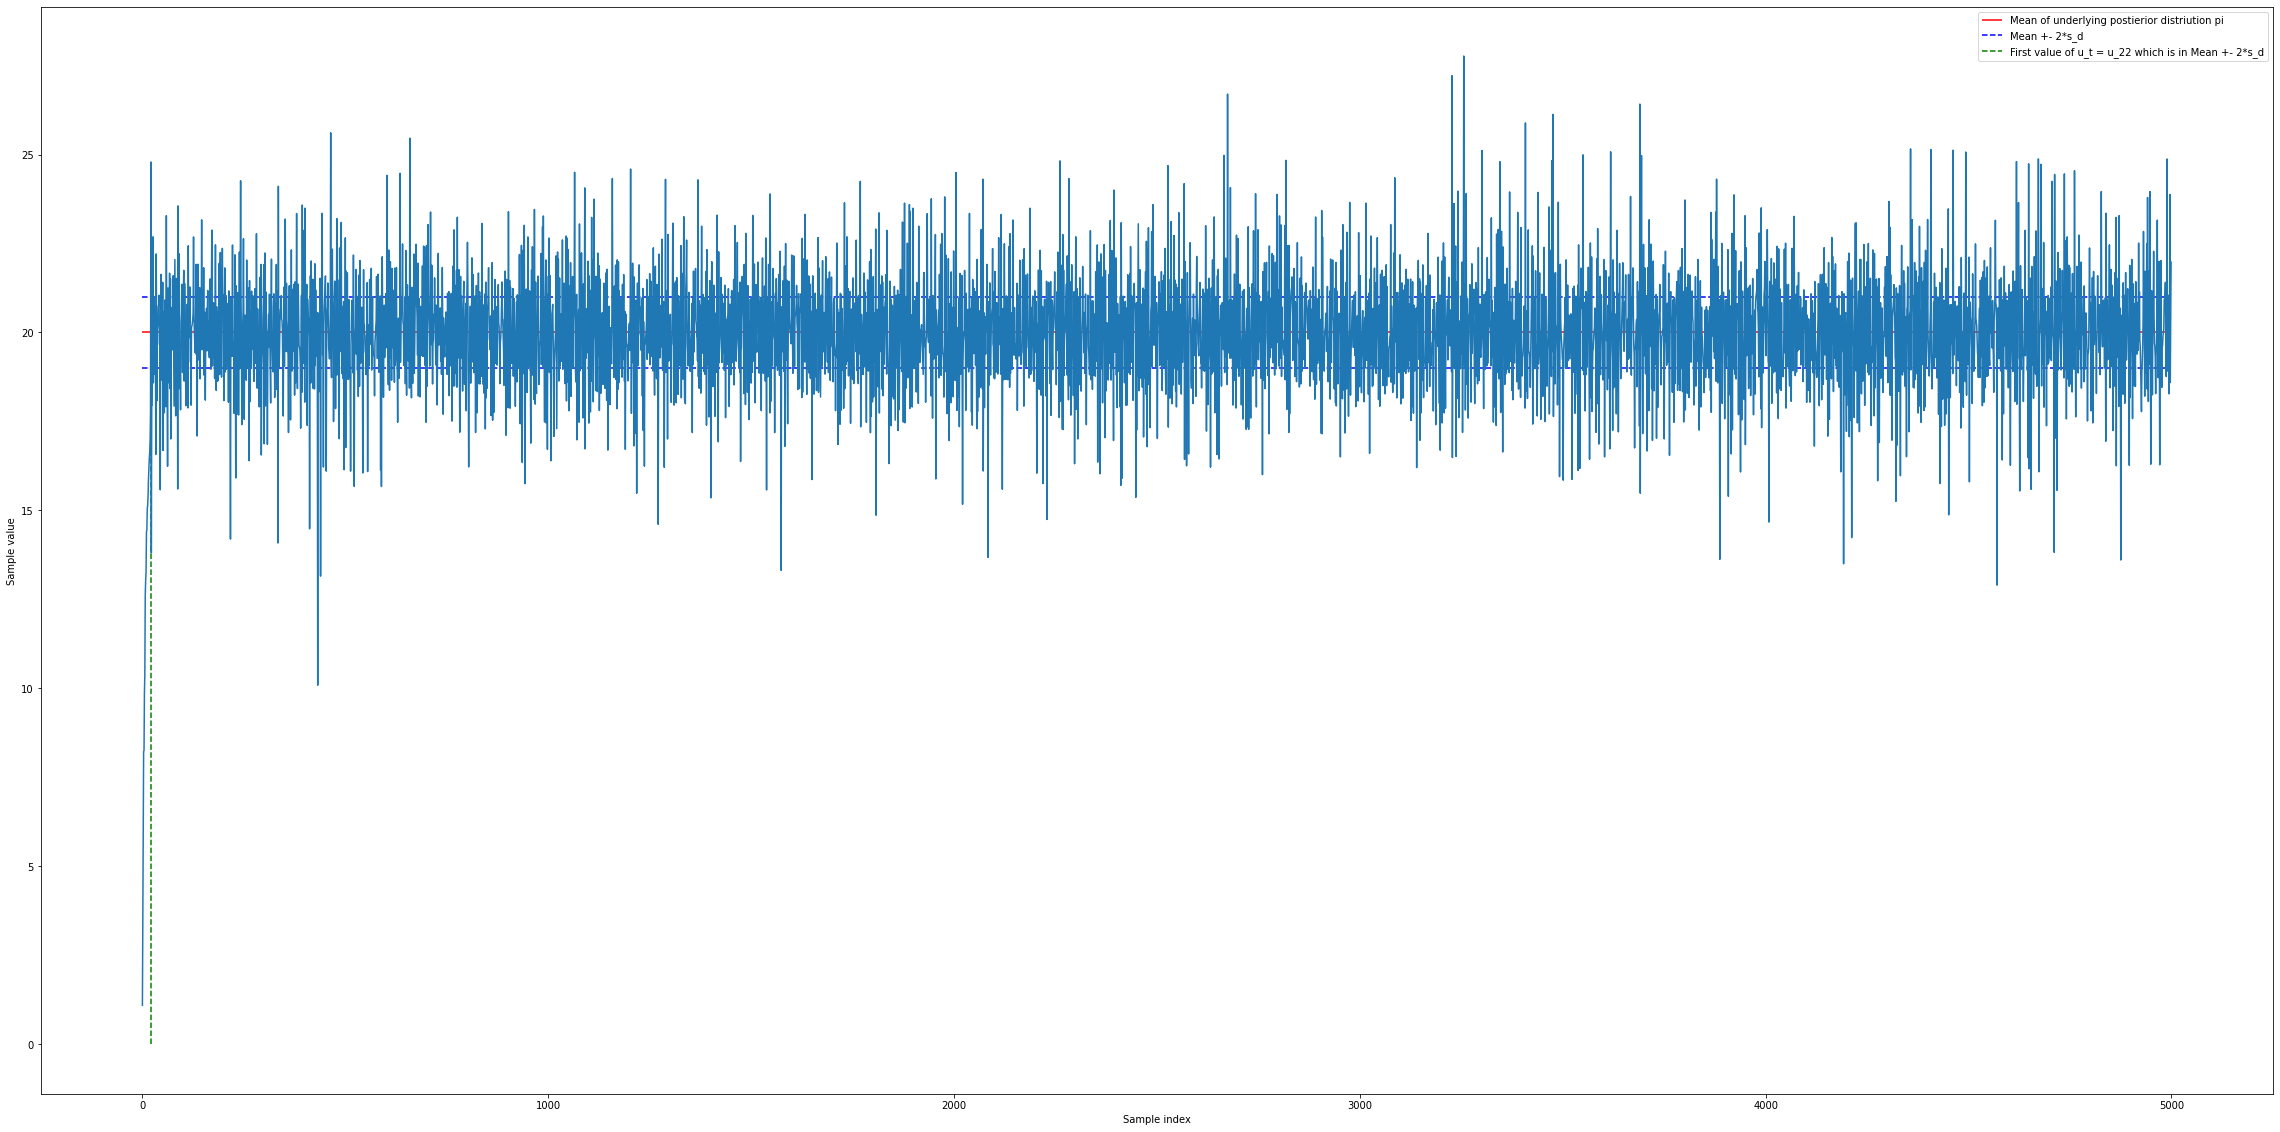

In [24]:
sample_index = [i for i in range(len(all_samples))]

fig, ax = plt.subplots(figsize=(40, 20))
plt.plot(sample_index,all_samples)
mean = 20
s_d = 0.5
index = 0 

ax.hlines(mean, 0, len(all_samples), "r",label = "Mean of underlying postierior distriution pi")
ax.hlines(mean-2*s_d, 0, len(all_samples), "b",'--',label = "Mean +- 2*s_d")
ax.hlines(mean+2*s_d, 0, len(all_samples), "b",'--')

for u in all_samples:
    index+=1
    if(u > mean-2*s_d):
        break

ax.vlines(index, 0, 22, "g",'--',label = "First value of u_t = u_{} which is in Mean +- 2*s_d".format(index))
ax.set_ylabel('Sample value')
ax.set_xlabel('Sample index')
ax.legend()

In [25]:
u_samples_non, all_samples_non, list_acceptance_probaility = MH_A_1D(2.3,5000,proposed_density_random_walk)

<ipython-input-6-962d1443d3a3>:43: RuntimeWarning: divide by zero encountered in true_divide
  acceptance_probaility = float(min([1,numerator/denominator]))


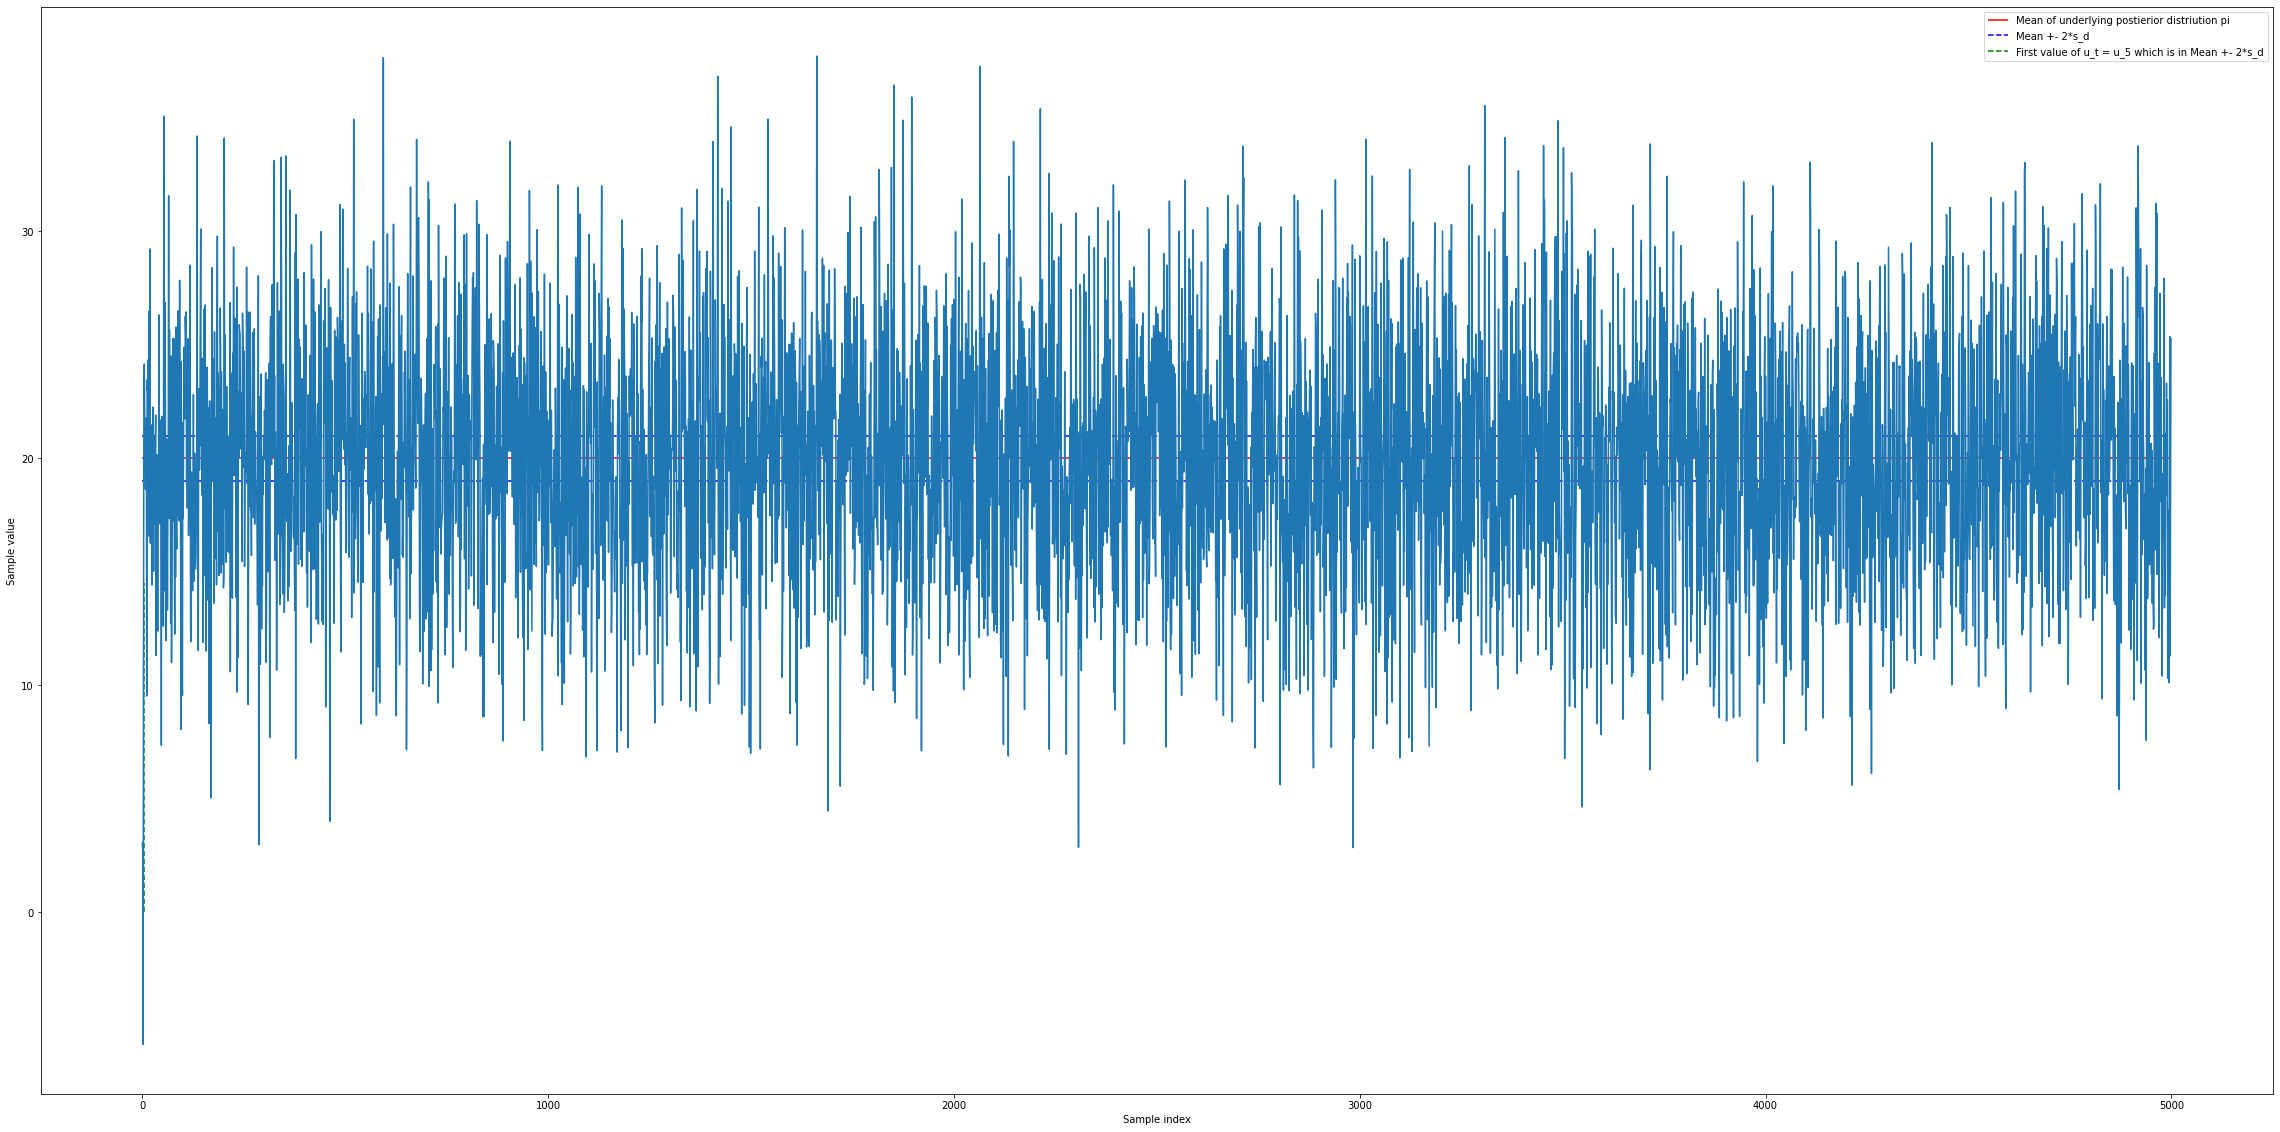

In [26]:
samples = all_samples_non
sample_index = [i for i in range(len(samples))]

fig, ax = plt.subplots(figsize=(40, 20))
plt.plot(sample_index,samples)
mean = 20
s_d = 0.5
index = 0 

ax.hlines(mean, 0, len(samples), "r",label = "Mean of underlying postierior distriution pi")
ax.hlines(mean-2*s_d, 0, len(samples), "b",'--',label = "Mean +- 2*s_d")
ax.hlines(mean+2*s_d, 0, len(samples), "b",'--')

for u in samples:
    index+=1
    if(u > mean-2*s_d):
        break

ax.vlines(index, 0, 14.5, "g",'--',label = "First value of u_t = u_{} which is in Mean +- 2*s_d".format(index))
ax.set_ylabel('Sample value')
ax.set_xlabel('Sample index')
ax.legend()

In [47]:
asymptotic_variance(all_samples_non), asymptotic_variance(all_samples)

(135898.9677214252, 12370.505092808271)

In [48]:
N_s = [10**i for i in range(2,5)]
asymp_variances_reversible = []
asymp_variances_non_reversible = []

for N in N_s:
    print(N)
    asymp_var_reversible = asymptotic_variance(MH_A_1D(2.1,N,proposed_density_random_walk)[0])
    asymp_variances_reversible.append(asymp_var_reversible)
    
    asymp_var_non_reversible = asymptotic_variance(Non_Reversible_MH_A(1,N)[0])
    asymp_variances_non_reversible.append(asymp_var_non_reversible)

100


<ipython-input-6-962d1443d3a3>:43: RuntimeWarning: divide by zero encountered in true_divide
  acceptance_probaility = float(min([1,numerator/denominator]))


1000
10000


<ipython-input-6-962d1443d3a3>:43: RuntimeWarning: invalid value encountered in true_divide
  acceptance_probaility = float(min([1,numerator/denominator]))


In [49]:
asymp_variances_reversible, asymp_variances_non_reversible

([227.40850210039807, 493.96400077910096, 4481.118529175228],
 [514.9978937515758, 1577.7344707850098, 3191.395219759659])